# 2D Advection-Diffusion equation

in this notebook we provide a simple example of the DeepMoD algorithm and apply it on the 2D advection-diffusion equation. 

In [22]:
# General imports
import numpy as np
import torch
import matplotlib.pylab as plt
# DeepMoD stuff
from deepymod_torch.DeepMod import DeepMod
from deepymod_torch.library_functions import library_2Din_1Dout
from deepymod_torch.training import train_deepmod, train_mse
from scipy.io import loadmat
# Settings for reproducibility
np.random.seed(42)
torch.manual_seed(0)


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Prepare the data

Next, we prepare the dataset.

In [23]:
data = loadmat('data/Advection_diffusion.mat')
usol = np.real(data['Expression1'])
usol= usol.reshape((51,51,61,4))

x_v= usol[:,:,:,0]
y_v = usol[:,:,:,1]
t_v = usol[:,:,:,2]
u_v = usol[:,:,:,3]

Next we plot the dataset for three different time-points

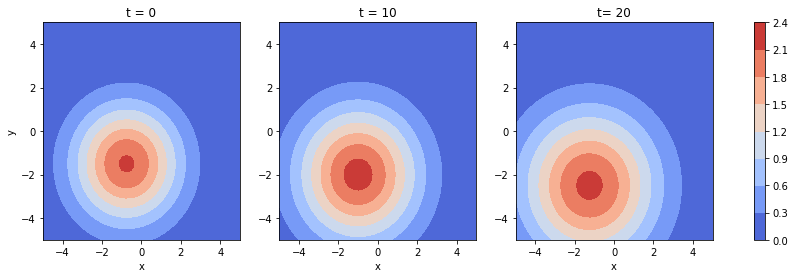

In [3]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 4))

im0 = axes[0].contourf(x_v[:,:,0], y_v[:,:,0], u_v[:,:,0], cmap='coolwarm')
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')
axes[0].set_title('t = 0')

im1 = axes[1].contourf(x_v[:,:,10], y_v[:,:,10], u_v[:,:,10], cmap='coolwarm')
axes[1].set_xlabel('x')
axes[1].set_title('t = 10')

im2 = axes[2].contourf(x_v[:,:,20], y_v[:,:,20], u_v[:,:,20], cmap='coolwarm')
axes[2].set_xlabel('x')
axes[2].set_title('t= 20')

fig.colorbar(im1, ax=axes.ravel().tolist())

plt.show()

We flatten it to give it the right dimensions for feeding it to the network:

In [32]:
X = np.transpose((t_v.flatten(),x_v.flatten(), y_v.flatten()))
y = np.float32(u_v.reshape((u_v.size, 1)))

We select the noise level we add to the data-set

In [33]:
noise_level = 0.01

In [34]:
y_noisy = y + noise_level * np.std(y) * np.random.randn(y.size, 1)

Select the number of samples:

In [35]:
number_of_samples = 1000

In [8]:
idx = np.random.permutation(y.size)
X_train = X[idx, :][:number_of_samples]
y_train = y_noisy[idx, :][:number_of_samples]

In [36]:
number_of_samples = 1000

idx = np.random.permutation(y.shape[0])
X_train = torch.tensor(X[idx, :][:number_of_samples], dtype=torch.float32, requires_grad=True)
y_train = torch.tensor(y[idx, :][:number_of_samples], dtype=torch.float32)

## Configure the neural network

In [37]:
## Running DeepMoD
config = {'n_in': 3, 'hidden_dims': [20, 20, 20, 20, 20, 20], 'n_out': 1, 'library_function': library_2Din_1Dout, 'library_args':{'poly_order': 1, 'diff_order': 2}}

Now we instantiate the model:

In [38]:
model = DeepMod(**config)
optimizer = torch.optim.Adam([{'params': model.network_parameters(), 'lr':0.001}, {'params': model.coeff_vector(), 'lr':0.005}])

## Run DeepMoD 

We can now run DeepMoD using all the options we have set and the training data. We need to slightly preprocess the input data for the derivatives:

In [41]:
train_deepmod(model, X_train, y_train, optimizer, 25000, {'l1': 1e-5})

| Iteration | Progress | Time remaining |     Cost |      MSE |      Reg |       L1 |
      25000    100.00%               0s   2.60e-05   2.09e-06   5.13e-06   1.88e-05 
[Parameter containing:
tensor([[0.2501],
        [0.4927],
        [0.4943],
        [0.4837]], requires_grad=True)]
[tensor([1, 2, 3, 4])]

| Iteration | Progress | Time remaining |     Cost |      MSE |      Reg |       L1 |
      25000    100.00%               0s   1.36e-05   2.09e-06   1.15e-05   0.00e+00 